<a href="https://colab.research.google.com/github/BrunoPinos/Categoriser-automatiquement-des-questions/blob/add_API/P5_unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# data analysis and wrangling
import pandas as pd
from scipy import stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

# text
from gensim.models import LdaMulticore
from gensim.models import Phrases, CoherenceModel
from IPython.display import display, HTML

# Save objects
import joblib

# Set working directory
import time
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/P5')

# Data table display for Pandas dataframes
from google.colab import data_table
%load_ext google.colab.data_table

Import

In [2]:
corpus = joblib.load('corpus.sav')
dictionary = joblib.load('dictionary.sav')
df = joblib.load('df.sav')
texts_cleaned = joblib.load('texts_cleaned.sav')

# Modeling phase
In order to be able to categorize the questions of our corpus in an unsupervised way, we use Mallet's implementation of Latent Dirichlet Allocation (LDA). We train several models with a pre-indicated number of subjects around which to group documents, and look for the best according to the consistency value.

In [3]:
# Initialization
start, limit, step = 8, 20, 2
coherence_values = []
model_list = []


# Processing
for num_topics in range(start, limit, step):
    start = time.time()

    model = LdaMulticore(corpus, id2word=dictionary, num_topics=num_topics)
    model_list.append(model)
    coherencevalue = CoherenceModel(model=model, texts=texts_cleaned,
                                    dictionary=dictionary).get_coherence()
    coherence_values.append(coherencevalue)

    # display training information along the way
    minutes, seconds = divmod(time.time()-start, 60)

    str_perf = f"Nombre de topics: {num_topics:2} ... Valeur de coherence: {coherencevalue:.3} ... "
    str_time = f"Temps d'entrainement et d'évaluation: {round(minutes):2} minutes {round(seconds):2} secondes..."
    print(str_perf + str_time)

Nombre de topics:  8 ... Valeur de coherence: 0.473 ... Temps d'entrainement et d'évaluation:  1 minutes 34 secondes...
Nombre de topics: 10 ... Valeur de coherence: 0.429 ... Temps d'entrainement et d'évaluation:  1 minutes 38 secondes...
Nombre de topics: 12 ... Valeur de coherence: 0.488 ... Temps d'entrainement et d'évaluation:  1 minutes 37 secondes...
Nombre de topics: 14 ... Valeur de coherence: 0.498 ... Temps d'entrainement et d'évaluation:  1 minutes 41 secondes...
Nombre de topics: 16 ... Valeur de coherence: 0.514 ... Temps d'entrainement et d'évaluation:  1 minutes 43 secondes...
Nombre de topics: 18 ... Valeur de coherence: 0.474 ... Temps d'entrainement et d'évaluation:  1 minutes 42 secondes...


Let us represent graphically the evolution of coherence

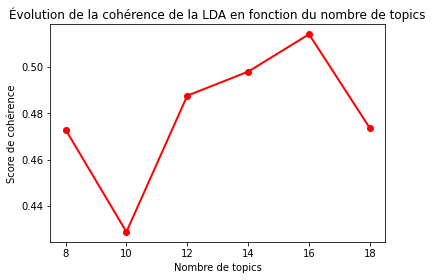

In [4]:
n_topics = range(8, limit, step)
plt.plot(n_topics, coherence_values, 'r-', linewidth='2')
plt.plot(n_topics, coherence_values, 'ro', linewidth='5')
plt.xlabel("Nombre de topics")
plt.ylabel("Score de cohérence")
plt.title("Évolution de la cohérence de la LDA en fonction du nombre de topics");

# Results interpretation

We choose to keep the 10 topic model as the final model. Indeed, according to our evolution curve, we notice that the coherence value reaches a plateau from this value, and only deviates very slightly for the number of following topics.

In [13]:
optimal_model = model_list[4]

joblib.dump(optimal_model, 'optimal_model.sav')

['optimal_model.sav']

For each topic that emerges, let's display the list of the most probable words.

In [14]:
for i in range(optimal_model.num_topics):
    desc = optimal_model.show_topic(i, topn=10)
    words = ', '.join([word for word, prob in desc])
    print(f'Topic #{i+1:2}:\n\t', words)

Topic # 1:
	 page, php, html, javascript, browser, css, http, ie, content, com
Topic # 2:
	 memory, size, large, performance, x, point, take, number, small, fast
Topic # 3:
	 image, view, text, display, color, style, background, tab, pdf, template
Topic # 4:
	 net, build, app, application, version, framework, tool, system, library, assembly
Topic # 5:
	 table, database, sql, query, server, store, mysql, key, linq, field
Topic # 6:
	 java, test, parameter, xml, eclipse, unit, pass, variable, argument, jar
Topic # 7:
	 class, property, c, interface, implement, define, instance, reference, static, implementation
Topic # 8:
	 git, folder, repository, delete, svn, copy, commit, quot, header, directory
Topic # 9:
	 command, script, directory, path, output, window, expression, variable, text, match
Topic #10:
	 python, print, module, library, json, package, parse, byte, encode, character
Topic #11:
	 server, net, service, web, asp, request, client, application, access, http
Topic #12:
	 form,

For each document, let's find the topic that contributes the most to its distribution of words

In [17]:
dominant_topics = []
perc_contributions = []

for predictions in optimal_model[corpus]:
    predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    topic_num, topic_contrib = predictions[0] # Get most contributing topic
    dominant_topics.append(int(topic_num+1))
    perc_contributions.append(round(topic_contrib, 4))
    
docs_dominants = pd.DataFrame({'Dominant Topic': dominant_topics,
                               'Contribution': perc_contributions,
                               'Index': texts_cleaned.index})
docs_dominants.set_index(['Index'], inplace=True)
docs_dominants

,Dominant Topic,Contribution
Index,,
10000005,14,0.7369
10000083,7,0.4020
10000335,15,0.2511
10003270,14,0.3365
10003562,3,0.4234
...,...,...
1213074,13,0.3550
1213127,13,0.6187
1213137,3,0.7079


With this new frame, let's try to segment our dataset by calculating:

1.   the number of documents per contributor top topic
2.   the proportion of documents by contributor top topic

In [18]:
# Number of documents for each topic
docs_per_topic = (docs_dominants['Dominant Topic']
                  .value_counts(sort=False)
                  .to_frame()
                  .rename(columns={'Dominant Topic': 'Document count'})
                 )

# Proportion of documents for each topic
topic_props = (docs_per_topic.divide(docs_per_topic.sum())
               .round(4)
               .rename(columns={'Document count': 'Document proportion'})
              )

Let's attach this information with the descriptor keywords of the topics

In [19]:
# Most probable keywords per topic
keywords = []
for i in range(optimal_model.num_topics):
    desc = optimal_model.show_topic(i)
    keywords.append(', '.join([word for word, prob in desc]))

num_topics = [i+1 for i in range(optimal_model.num_topics)]
df_topics_keywords = pd.DataFrame({'Topic #': num_topics, 'Keywords': keywords})
df_topics_keywords.set_index(['Topic #'], inplace=True)

# Final Frame
df_dominant_topics = df_topics_keywords.join([docs_per_topic, topic_props])
df_dominant_topics.sort_values(['Document proportion'], ascending=False, inplace=True)
df_dominant_topics

,Keywords,Document count,Document proportion
Topic #,,,
7,"class, property, c, interface, implement, defi...",10175,0.1004
11,"server, net, service, web, asp, request, clien...",9074,0.0895
4,"net, build, app, application, version, framewo...",7640,0.0754
5,"table, database, sql, query, server, store, my...",7641,0.0754
1,"page, php, html, javascript, browser, css, htt...",7533,0.0743
14,"list, array, column, row, index, key, loop, el...",7112,0.0702
9,"command, script, directory, path, output, wind...",6898,0.0681
13,"application, thread, exception, visual, proces...",6584,0.0650
15,"c, program, difference, language, ruby, linux,...",5810,0.0573


I try on the second exemple of the notebook cleaned

In [69]:
example = corpus.iloc[38000]

predictions = optimal_model[example]
predictions = sorted(predictions, key=lambda x: x[1], reverse=True)

topic_num, topic_contrib = predictions[0]

desc = optimal_model.show_topic(topic_num, topn=20)

keywords = [word for word, prob in desc]

tags = {lemma for lemma in texts_cleaned.iloc[38000] if lemma in keywords}

display(HTML(df.loc[corpus.index[38000], 'Body']))
print("-"*30, '\nTags proposés: ')
print(tags)

------------------------------ 
Tags proposés: 
{'column', 'excel', 'loop', 'row'}


In more detail, we will take here several examples to which we will suggest tags. To do this, we will search among the key words characteristic of the dominant topic of the said example those which appear there. These examples that we select are considered to be the most representative of each area.

In [54]:
top_categories = (docs_dominants.sort_values(['Contribution'],ascending=False)
                  .groupby(['Dominant Topic'], sort=False)
                  .head(1)
                  .sort_values(['Dominant Topic'])
                  .reset_index().set_index(['Dominant Topic'])
                 )

examples = (top_categories
            .join(corpus.apply(len).to_frame('Length'), 'Index')
            .sort_values('Length', ascending=False).Index)

def show_example(corpus, lemmas, data, examples, model, n_ex):
    predictions = model[corpus[examples.iloc[n_ex]]]
    predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    
    topic_num, topic_contrib = predictions[0]
    desc = optimal_model.show_topic(topic_num, topn=20)
    
    keywords = [word for word, prob in desc]
    tags = {lemma for lemma in lemmas[examples.iloc[n_ex]] if lemma in keywords}

    display(HTML(data.loc[examples.iloc[n_ex], 'Body']))
    print("-"*30, '\nTags proposés: ')
    print(tags)


show_example(corpus, texts_cleaned, df, examples, optimal_model, 1)

18665171